# Magflow

En este proyecto se trata de analizar comparativamente los estudios de resonancia de flujo realizados a 20 pacientes con implante TAVI.

## Configuración

Importación de las librerías necesarias del proyecto.

In [1]:
# Standard library imports
import os
from pathlib import Path
import json

# Third-party imports
import numpy as np
import pyvista as pv
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Local imports
import magflow.utils.visualization as visualization

# For notebook integration
from IPython.display import display, Markdown

%matplotlib inline
pv.set_jupyter_backend("static")
pv.global_theme.allow_empty_mesh = True

## Carga de datos

Se cargan los datos en formato `vtk` de tanto del campo de velocidades como de la geometría aórtica segmentada previamente en *3D Slicer*.

Por defecto, se carga el instante de tiempo **85** dado que coincide con el instante de sístole y, por tanto, presenta mayor contraste.

In [7]:
# Parameters
data_dir = Path("../../data")
timestep = 85  # Default timestep (systole phase)

# List available timesteps
available_files = [f for f in os.listdir(data_dir) if f.startswith("data.vts.")]
available_timesteps = [int(f.split(".")[-1]) for f in available_files]
available_timesteps.sort()

# Display available timesteps as markdown
print(f"Available Timesteps: {available_timesteps}")

# Construct the full filepath for the selected timestep data
filename = f"data.vts.{timestep}"
filepath = data_dir / filename

# Validate that the requested timestep file exists
if not filepath.exists():
    print(f"[bold]Error:[/bold] File {filepath} not found.")
    print(f"Please select from available timesteps: {available_timesteps}")
else:
    # Load the VTS dataset for the selected timestep
    dataset = pv.read(str(filepath), force_ext=".vts")

    print(f"Velocity field dimensions: {dataset.dimensions}")

Available Timesteps: [0, 28, 57, 85, 113, 141, 170, 198, 226, 254, 283, 311, 339, 368, 396, 424, 452, 481, 509, 537, 566, 594, 622, 650]
Velocity field dimensions: (128, 128, 40)


Se carga la geometría aórtica obtenida previamente en *3DSlicer* a partir de la segmentación de las imágenes de la resonancia magnética del paciente.

In [3]:
# Load the biomodel data
biomodel_path = Path("../../assets/biomodel.vtk")
biomodel_data = visualization.load_biomodel(biomodel_path)

También de deberán cargar los puntos de la línea central con el fin de crear secciones equiespaciadas a lo largo de la geometría aórtica.

Se ha utilizado el plugin *VMTK* de *3DSlicer* para obtener la línea central del propio biomodelo.

Al igual que en el biomodelo, se deben de aplicar rotación y traslación para conseguir la alineación.

In [4]:
# Load the centreline data from JSON file
centreline_path = Path("../../assets/centreline.json")
with open(centreline_path, "r") as f:
    data = json.load(f)
    # Extract control points
    control_points = data["markups"][0]["controlPoints"]
    # Extract positions and orientations
    positions = []
    for point in control_points:
        # Skip incomplete points
        if "position" not in point:
            continue

        positions.append(point["position"])

# Convert positions and orientations to numpy arrays
centreline_points = np.array(positions)

# Adjust coordinates
# centreline_points[:, 2] = -centreline_points[:, 2]
centreline_points[:, 2] += 300
rotation_matrix = np.array([[0, 1, 0], [0, 0, 1], [-1, 0, 0]])
centreline_points = centreline_points @ rotation_matrix.T

## 3. Visualización

A partir de la librería *PyVista* se renderiza el campo de velocidades para el paciente e instante de tiempo seleccionado.

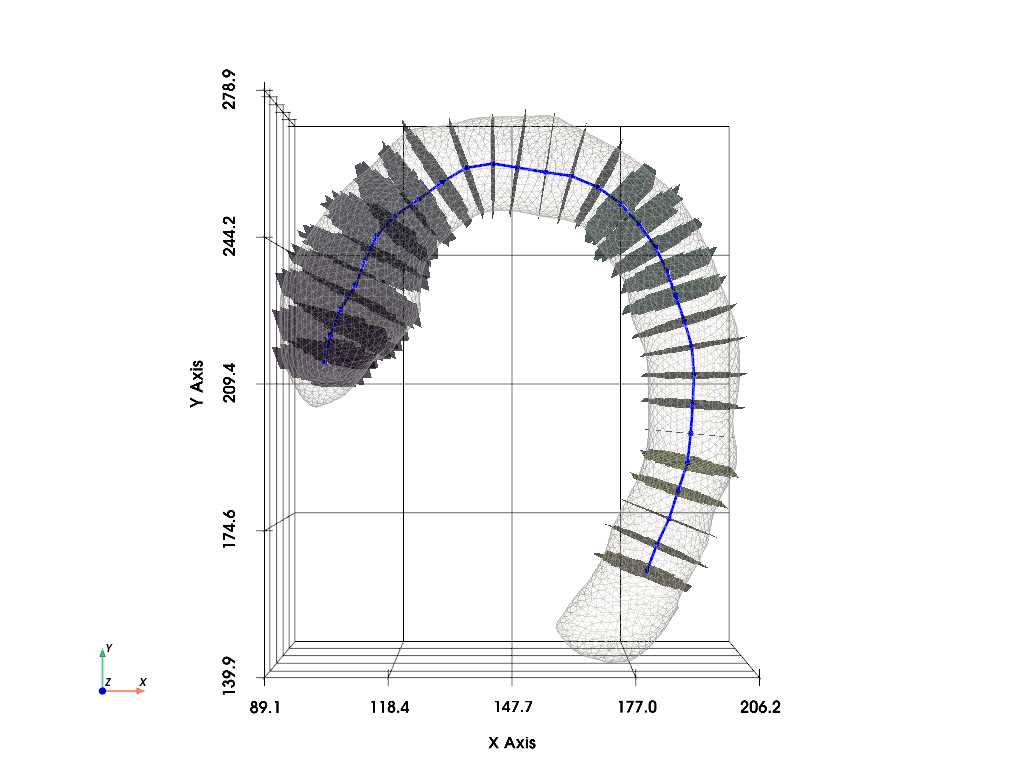

In [5]:
# Initialize the PyVista plotter for 3D visualization
plotter = pv.Plotter(notebook=True)

# Extract aorta region from dataset
aorta = visualization.extract_aorta(dataset, biomodel_data)
centreline_points = visualization.resample(centreline_points, num_points=30)
cross_sections = visualization.ortoplanes(centreline_points, aorta, radius=25)

# Add biomodel as a wireframe to provide anatomical context
plotter.add_mesh(
    biomodel_data,
    color="white",
    opacity=0.2,
    label="Biomodel",
    show_edges=True,
    edge_color="black",
    style="wireframe",
)

# Add a line connecting all points
centreline = pv.PolyData(centreline_points)
centreline.lines = np.hstack(
    [len(centreline_points), np.arange(len(centreline_points))]
)
plotter.add_mesh(centreline, color="blue", line_width=3)

# Add each cross-section with a different color
colors = cm.viridis(np.linspace(0, 1, len(cross_sections)))
for i, cross_section in enumerate(cross_sections):
    if cross_section.n_points > 0:  # Only add non-empty cross-sections
        plotter.add_mesh(
            cross_section,
            color=colors[i, :3],
            opacity=0.7,
            show_edges=True,
        )

# Configure camera and grid for optimal viewing
plotter.view_xy()
plotter.show_grid(font_size=12)
plotter.add_axes()

# Render the scene
plotter.show()

## 4. Análisis

Se analizarán los siguientes parámetros.

- Flujo volumétrico (m3/s)
- Velocidad máxima (m/s)
- TAWSS (Time-Averaged Wall Shear Stress) (Pa)
- OSI (Oscillatory Shear Index)
- Pérdida de carga.
- Gradientes de presión (Pa)
- Vorticidad.
- Helicidad.

### 4.1 Flujo volumétrico

El flujo volumétrico es la cantidad de volumen de sangre por unidad de tiempo que pasa por una sección aórtica. Se puede calcular a partir de la siguiente expresión:

$$
Q = v \cdot A
$$

Donde $v$ es la velocidad media de la sección y $A$ el área total de la sección.

Para poder comparar los valores de flujo volumétrico entre pacientes e instantes de tiempos se tomarán el valor medio de varias secciones generadas a lo largo de la línea central.

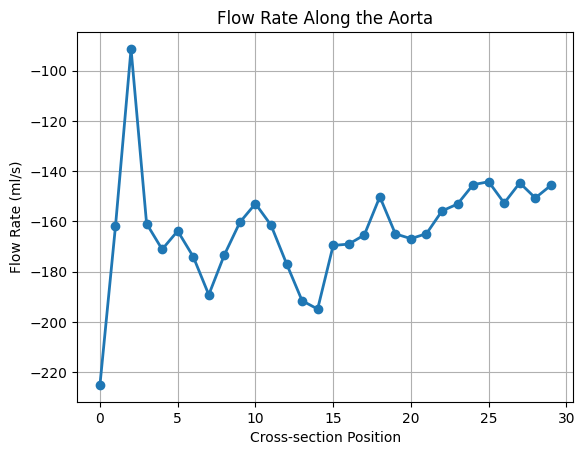

In [9]:
# Calculate volumetric flow rates across all cross-sections
flow_rates = []
cross_section_areas = []

for i, cross_section in enumerate(cross_sections):
    # Skip if the cross-section has no points
    if cross_section.n_points == 0:
        flow_rates.append(0)
        cross_section_areas.append(0)
        continue

    # Extract velocity vectors at each point in the cross-section
    velocity_vectors = cross_section["Velocity"] * 10  # Convert to mm/s

    # Get normals of the cross-section
    cross_section.compute_normals(cell_normals=False, point_normals=True, inplace=True)
    section_normals = cross_section["Normals"]

    # Calculate dot product of velocity and normal at each point
    normal_velocities = np.sum(velocity_vectors * section_normals, axis=1)

    # Calculate cell areas (for integration)
    cell_areas = np.zeros(len(normal_velocities))
    for cell_id in range(cross_section.n_cells):
        cell = cross_section.extract_cells(cell_id)
        area = cell.area
        point_ids = cross_section.get_cell(cell_id).point_ids
        for point_id in point_ids:
            cell_areas[point_id] += area / len(point_ids)

    # Calculate flow rate as sum of (velocity_normal * area) for each point
    section_flow_rate = np.sum(normal_velocities * cell_areas) / 1000  # Convert to ml/s
    section_area = np.sum(cell_areas)

    flow_rates.append(section_flow_rate)
    cross_section_areas.append(section_area)

# Convert to numpy array for easier manipulation
flow_rates = np.array(flow_rates)
cross_section_areas = np.array(cross_section_areas)

# Plot flow rate along the aorta
plt.figure()
plt.plot(range(len(flow_rates)), flow_rates, "o-", linewidth=2)
plt.title("Flow Rate Along the Aorta")
plt.xlabel("Cross-section Position")
plt.ylabel("Flow Rate (ml/s)")
plt.grid(True)
plt.show()